In [2]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

In [3]:
df = pd.read_excel('pollution_no_gas_cleaned.xlsx', engine='openpyxl')

## First 5 chemicals in water

In [19]:
# Filter wastewater and controlled waters data
df_filtered = df[df['ROUTE NAME'].isin(['wastewater', 'controlled waters'])]

# Count the count of SUBSTANCE names in each category
substance_counts = df_filtered.groupby(['ROUTE NAME', 'SUBSTANCE NAME']).size().reset_index(name='Count')

# Calculate the proportion of SUBSTANCE names in each category
substance_counts['Total'] = substance_counts.groupby('ROUTE NAME')['Count'].transform('sum')
substance_counts['Percentage'] = (substance_counts['Count'] / substance_counts['Total']) * 100

# Sort by Count in descending order and select the first five
top_substances = substance_counts.sort_values(by='Count', ascending=False).head(5)
print(substance_counts)

            ROUTE NAME                  SUBSTANCE NAME  Count  Total  \
0    controlled waters                          Aldrin      1   2584   
1    controlled waters                      Anthracene     98   2584   
2    controlled waters                         Arsenic    113   2584   
3    controlled waters                        Asbestos     96   2584   
4    controlled waters                        Atrazine      3   2584   
..                 ...                             ...    ...    ...   
105         wastewater  Trichlorobenzene - all isomers      3    411   
106         wastewater                     Trifluralin      8    411   
107         wastewater                  Vinyl chloride      1    411   
108         wastewater            Xylene - all isomers      7    411   
109         wastewater                            Zinc     26    411   

     Percentage  
0      0.038700  
1      3.792570  
2      4.373065  
3      3.715170  
4      0.116099  
..          ...  
105    0.

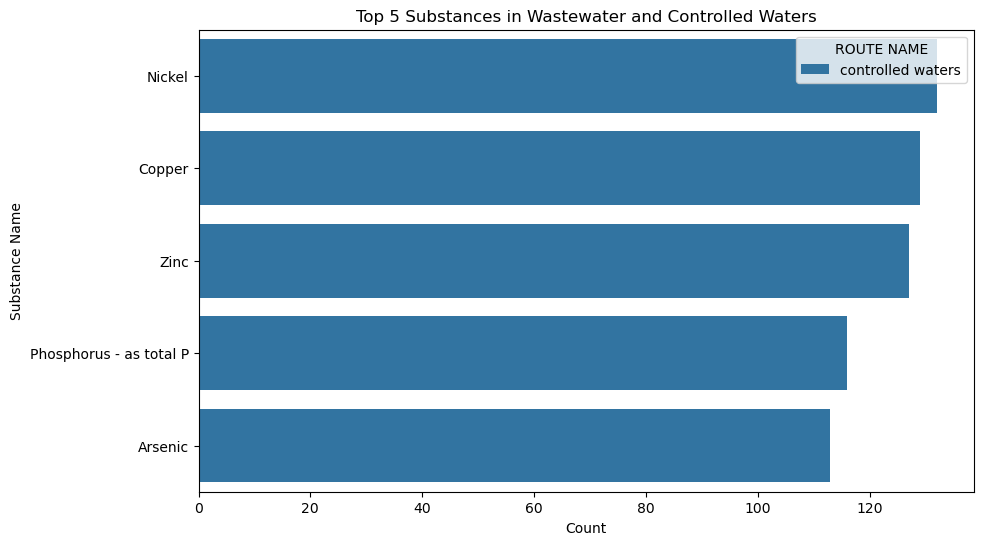

In [22]:
# Sort by Count in descending order and select the first five
top_substances = substance_counts.sort_values(by='Count', ascending=False).head(5)

# Visualize the statistics of the first five substances
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='SUBSTANCE NAME', hue='ROUTE NAME', data=top_substances)

plt.title('Top 5 Substances in Wastewater and Controlled Waters')
plt.xlabel('Count')
plt.ylabel('Substance Name')

plt.show()

## Nickel release situation in water

In [25]:

# Filter 'ROUTE NAME' to wastewater and controlled waters
df_filtered = df[df['ROUTE NAME'].isin(['wastewater', 'controlled waters'])]

# Filter na substance is nickel
df_nickel = df_filtered[df_filtered['SUBSTANCE NAME'] == 'Nickel']


# Create a category column based on the 'REPORTING THRESHOLD'
df_nickel['Release Level'] = df_nickel['QUANTITY RELEASED (kg)'] > df_nickel['REPORTING THRESHOLD (kg)']
df_nickel['Release Level'] = df_nickel['Release Level'].map({True: 'high', False: 'low'})

# create map
map_center = [df_nickel['Latitude'].mean(), df_nickel['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# color mapping in map
color_map = {'high': 'red', 'low': 'green'}

# Iterate over the data and add tags
for _, row in df_nickel.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,  
        color=color_map[row['Release Level']], 
        fill=True,
        fill_color=color_map[row['Release Level']],
        fill_opacity=0.6,
        popup=folium.Popup(f"Nickel Release: {row['QUANTITY RELEASED (kg)']}", parse_html=True)
    ).add_to(m)

# save and print map
m.save("nickel_release_map.html")
m


/var/folders/v4/ll7l29sx2k52mk2_vs_zrm_40000gn/T/ipykernel_35088/2898700566.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nickel['Release Level'] = df_nickel['QUANTITY RELEASED (kg)'] > df_nickel['REPORTING THRESHOLD (kg)']
/var/folders/v4/ll7l29sx2k52mk2_vs_zrm_40000gn/T/ipykernel_35088/2898700566.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nickel['Release Level'] = df_nickel['Release Level'].map({True: 'high', False: 'low'})


## Divide the high or low quantity released zones in controlled water according to threashold value

In [17]:
#  Filter the data whose route name is controlled water
filtered_df = df[df['ROUTE NAME'] == 'controlled waters']

# Classification based on the REPORTING THRESHOLD
def categorize_quantity(row):
    if row['QUANTITY RELEASED (kg)'] > row['REPORTING THRESHOLD (kg)']:
        return 'High'
    else:
        return 'Low'

# Create a new column 'Release Level' to separate the data into High and Low
filtered_df['Release Level'] = filtered_df.apply(categorize_quantity, axis=1)


# Create the map and adjust the center point
uk_center = [filtered_df['Latitude'].mean(), filtered_df['Longitude'].mean()]  
m = folium.Map(location=uk_center, zoom_start=6)

# Set the color mapping to High and Low respectively
color_map = {
    'Low': 'green',
    'High': 'red'
}

# Iterate through the DataFrame to add tags to each point
for _, row in filtered_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Route: {row['ROUTE NAME']}<br>Quantity Released: {row['QUANTITY RELEASED (kg)']}<br>Reporting Threshold: {row['REPORTING THRESHOLD (kg)']}<br>Level: {row['Release Level']}",
        tooltip=row['Release Level'],
        icon=folium.Icon(color=color_map[row['Release Level']])
    ).add_to(m)

# Save and view the map
m

/var/folders/v4/ll7l29sx2k52mk2_vs_zrm_40000gn/T/ipykernel_35088/473907507.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Release Level'] = filtered_df.apply(categorize_quantity, axis=1)


## Divide the high or low quantity released zones in wastewater according to threashold value

In [18]:
#  Filter the data whose route name is wastewater
filtered_df = df[df['ROUTE NAME'] == 'wastewater']

# Classification based on the REPORTING THRESHOLD
def categorize_quantity(row):
    if row['QUANTITY RELEASED (kg)'] > row['REPORTING THRESHOLD (kg)']:
        return 'High'
    else:
        return 'Low'

# Create a new column 'Release Level' to separate the data into High and Low
filtered_df['Release Level'] = filtered_df.apply(categorize_quantity, axis=1)


# Create the map and adjust the center point
uk_center = [filtered_df['Latitude'].mean(), filtered_df['Longitude'].mean()]  # 计算中心点
m = folium.Map(location=uk_center, zoom_start=6)

# Set the color mapping to High and Low respectively
color_map = {
    'Low': 'green',
    'High': 'red'
}

# Iterate through the DataFrame to add tags to each point
for _, row in filtered_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Route: {row['ROUTE NAME']}<br>Quantity Released: {row['QUANTITY RELEASED (kg)']}<br>Reporting Threshold: {row['REPORTING THRESHOLD (kg)']}<br>Level: {row['Release Level']}",
        tooltip=row['Release Level'],
        icon=folium.Icon(color=color_map[row['Release Level']])
    ).add_to(m)

# Save and view the map
m

/var/folders/v4/ll7l29sx2k52mk2_vs_zrm_40000gn/T/ipykernel_35088/3861830868.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Release Level'] = filtered_df.apply(categorize_quantity, axis=1)
